# Instructions on how to run the notebook
The experiments notebook was written in order to work with the olympics 100m dataset.
If running all the blocks in the notebook, all the operations will be performed automatically.

If you want to run the blocks individually, follow the instructions below:
### Performing validation of the model
1. Run block in section 1 to import the necessary libraries
2. Run block in section 2 to prepare the datasets
3. Run blocks in section 3 to perform the validation on the model

### Testing our best model on the test set
1. All the blocks for the validation of the model must be run at least once
2. Run blocks in section 4 to predict on the test set prepared in section 2

### Comparison between our model and sklearn's model
1. All the blocks for the validation of the model must be run at least once
2. Run blocks in section 5 to compare the results of our model and sklearn's model




# 1-Import needed libraries

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2-Prepare training and test set

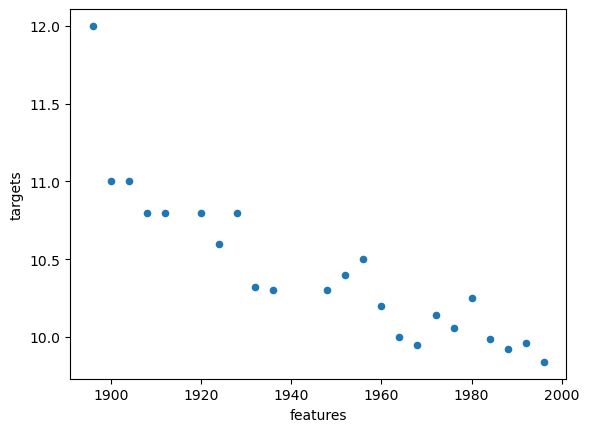

In [9]:
olympics=0
if olympics==0:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    #create using scikit learn a 2 numerical features dataset with 100 samples from a linear distribution
    from sklearn.datasets import make_regression
    X,Y=make_regression(n_samples=100, n_features=2, noise=100)
    dataset=pd.DataFrame({'features':X[:,0],'features2':X[:,1],'targets':Y})
from sklearn.model_selection import train_test_split
dataset_train,dataset_test=train_test_split(dataset,test_size=0.2, shuffle=False)
X=dataset_train.drop('targets',axis=1).values.reshape(-1,dataset_train.shape[1]-1)
Y=dataset_train['targets'].values.reshape(-1,1)

#plot
if dataset_train.shape[1]==2:
    dataset_train.plot.scatter(x='features',y='targets')

# 3-Perform validation

In [10]:
#coarse to fine approach
from ridge import Ridge_Regression
## given the low amount of data available we wanted to do a K-fold leave-one-out cross validation but, given the time constraint, we had to settle for a Time Series Split Cross-Validation.
## this is taken from this article https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4 where the logic is explained.
## we chose the hyper-parameter lambda following a coarse to fine approach
## the search is done by firstly selecting the magnitude (with a range from 10^10 to 10^-10) and then searching around it
k=int(len(X)/2)
lambda_mses=[]
lambda_mses_normalized=[]
# generates the intervals for the coarse to fine approach from 10^10 to 10^-10
lambda_values=np.array(10.0 ** np.arange(10, -10, -1))
for lambda_value in lambda_values:
    # print('Lambda value: ',lambda_value)
    ## for normalized lambda values
    ridge=Ridge_Regression(lambda_value,normalize=True)
    mses=[]
    for i in range(len(X)-k,len(X),1):
        # it starts with a training set of len(X) - k samples and then compute the mse on the next
        # sample. It then adds this sample to the training set and repeat the process. A picture is
        # given in the article linked above and on the report
        Xi=X[:i]
        Yi=Y[:i]
        ridge.Train(Xi,Yi)
        y_pred=ridge.Predict(X[i].reshape(1,-1))
        mses.append(((Y[i]-y_pred)**2).mean())
    lambda_mses_normalized.append(np.mean(mses))
    print('lambda_normalized: ',lambda_value,' mse: ',np.mean(mses))
    # for non normalized lambda values
    ridge=Ridge_Regression(lambda_value,normalize=False)
    mses=[]
    for i in range(len(X)-k,len(X),1):
        Xi=X[:i]
        Yi=Y[:i]
        ridge.Train(Xi,Yi)
        y_pred=ridge.Predict(X[i].reshape(1,-1))
        mses.append(((Y[i]-y_pred)**2).mean())
    lambda_mses.append(np.mean(mses))
    print('lambda: ',lambda_value,' mse: ',np.mean(mses))
print('best normalized lambda atm: ',lambda_values[np.argmin(lambda_mses_normalized)])
print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
lambda_value=lambda_values[np.argmin(lambda_mses)]
lambda_value_normalized=lambda_values[np.argmin(lambda_mses_normalized)]

lambda_normalized:  10000000000.0  mse:  0.2945029692994248
lambda:  10000000000.0  mse:  0.29450216855244804
lambda_normalized:  1000000000.0  mse:  0.29450295818829547
lambda:  1000000000.0  mse:  0.29449495087889566
lambda_normalized:  100000000.0  mse:  0.2945028470770358
lambda:  100000000.0  mse:  0.29442279001485133
lambda_normalized:  10000000.0  mse:  0.2945017359676625
lambda:  10000000.0  mse:  0.29370276516480687
lambda_normalized:  1000000.0  mse:  0.2944906251961974
lambda:  1000000.0  mse:  0.2866576063118312
lambda_normalized:  100000.0  mse:  0.29437954970035746
lambda:  100000.0  mse:  0.22899801649651244
lambda_normalized:  10000.0  mse:  0.2932720084548524
lambda:  10000.0  mse:  0.05863995720421758
lambda_normalized:  1000.0  mse:  0.28250999098720325
lambda:  1000.0  mse:  0.028807786046514808
lambda_normalized:  100.0  mse:  0.1998054916806767
lambda:  100.0  mse:  0.04522416484871012
lambda_normalized:  10.0  mse:  0.02960796022510516
lambda:  10.0  mse:  0.0478

In [11]:
# searching around the discovered magnitude to find the best lambda
# for doing so, I started digging from a higher magnitude and then I split the interval in 20 parts every time. This is done until the magnitude is 10^-10 so that I can get a good precision of the lambda value.
order_of_magnitude=lambda_value
for order in np.array(10.0 ** np.arange(np.log10(order_of_magnitude)+1, -10, -1)):
    lambda_values=np.linspace(max(lambda_value-1*order,0),lambda_value+1*order,num=(20+1))
    lambda_mses=[]
    for lambda_value in lambda_values:
        # print('lambda_value: ',lambda_value)
        ridge=Ridge_Regression(lambda_value,normalize=False)
        mses=[]
        for i in range(len(X)-k,len(X),1):
            Xi=X[:i]
            Yi=Y[:i]
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i].reshape(1,-1))
            mses.append(((Y[i]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
    best_mse = np.min(lambda_mses)
    lambda_value=lambda_values[np.argmin(lambda_mses)]
    

print('best lambda: ',lambda_value)
print('best mse: ',best_mse)

## now we do the same for the normalized version
order_of_magnitude=lambda_value_normalized
for order in np.array(10.0 ** np.arange(np.log10(order_of_magnitude)+1, -10, -1)):
    lambda_values=np.linspace(max(lambda_value_normalized-1*order,0),lambda_value_normalized+1*order,num=(20+1))
    lambda_mses_normalized=[]
    for lambda_value_normalized in lambda_values:
        # print('lambda_value: ',lambda_value)
        ridge=Ridge_Regression(lambda_value_normalized,normalize=True)
        mses=[]
        for i in range(len(X)-k,len(X),1):
            Xi=X[:i]
            Yi=Y[:i]
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i].reshape(1,-1))
            mses.append(((Y[i]-y_pred)**2).mean())
        lambda_mses_normalized.append(np.mean(mses))
    best_mse_normalized = np.min(lambda_mses_normalized)
    lambda_value_normalized=lambda_values[np.argmin(lambda_mses_normalized)]
    

print('best lambda normalized: ',lambda_value_normalized)
print('best mse normalized: ',best_mse_normalized)

best lambda:  2548.6512999945
best mse:  0.02172943027849049
best lambda normalized:  5.193053989999999
best mse normalized:  0.020799512063492467


# 4-Test the model on test set

In [12]:
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
y_pred=ridge.Predict(X_test)
mse=((Y_test-y_pred)**2).mean()
print('mse on test set: ',mse)
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
ridge=Ridge_Regression(lambda_value_normalized,normalize=True)
ridge.Train(X,Y)
y_pred=ridge.Predict(X_test)
mse=((Y_test-y_pred)**2).mean()
print('mse on test set using normalization: ',mse)

mse on test set:  0.022887067309294132
mse on test set using normalization:  0.011155019307648348


# 5-Comparison with SciKit Ridge Regression

In [13]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y) ## train on the training dataset
ridge_normalized=Ridge_Regression(lambda_value_normalized,normalize=True)
ridge_normalized.Train(X,Y) ## train on the training dataset
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
y_pred=ridge.Predict(X_test)
y_pred_normalized=ridge_normalized.Predict(X_test)
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(X_test)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_normalized=scaler.fit_transform(X)
X_test_normalized=scaler.transform(X_test)
ridge_sklearn_normalized=Ridge(alpha=lambda_value_normalized)
ridge_sklearn_normalized.fit(X_normalized,Y)
y_pred_sklearn_normalized=ridge_sklearn_normalized.predict(X_test_normalized)
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',Y_test[i])
    print('year: ',X_test[i],' time: ',y_pred[i])
    print('scikit: year: ',X_test[i],' time: ',y_pred_sklearn[i])
    print('normalized: year: ',X_test[i],' time: ',y_pred_normalized[i])
    print('scikit normalized: year: ',X_test[i],' time: ',y_pred_sklearn_normalized[i])
    
print('w_our: ',ridge.__str__())
print('w_sklearn: ',ridge_sklearn.coef_,ridge_sklearn.intercept_)
print('w_our normalized: ',ridge_normalized.__str__())
print('w_sklearn normalized: ',ridge_sklearn_normalized.coef_,ridge_sklearn_normalized.intercept_)
# mse on the test set
print('mse: ',((Y_test-ridge.Predict(X_test))**2).mean())
print('mse sklearn: ',((Y_test-ridge_sklearn.predict(X_test))**2).mean())
print('mse normalized: ',((Y_test-ridge_normalized.Predict(X_test))**2).mean())
print('mse sklearn normalized: ',((Y_test-ridge_sklearn_normalized.predict(X_test_normalized))**2).mean())

year:  [2000]  time:  [9.87]
year:  [2000]  time:  [9.78577941]
scikit: year:  [2000]  time:  [9.78577941]
normalized: year:  [2000]  time:  [9.84479641]
scikit normalized: year:  [2000]  time:  [9.84479641]
year:  [2004]  time:  [9.85]
year:  [2004]  time:  [9.73642036]
scikit: year:  [2004]  time:  [9.73642036]
normalized: year:  [2004]  time:  [9.79994697]
scikit normalized: year:  [2004]  time:  [9.79994697]
year:  [2008]  time:  [9.69]
year:  [2008]  time:  [9.68706131]
scikit: year:  [2008]  time:  [9.68706131]
normalized: year:  [2008]  time:  [9.75509752]
scikit normalized: year:  [2008]  time:  [9.75509752]
year:  [2012]  time:  [9.63]
year:  [2012]  time:  [9.63770226]
scikit: year:  [2012]  time:  [9.63770226]
normalized: year:  [2012]  time:  [9.71024808]
scikit normalized: year:  [2012]  time:  [9.71024808]
year:  [2016]  time:  [9.81]
year:  [2016]  time:  [9.58834321]
scikit: year:  [2016]  time:  [9.58834321]
normalized: year:  [2016]  time:  [9.66539864]
scikit normali

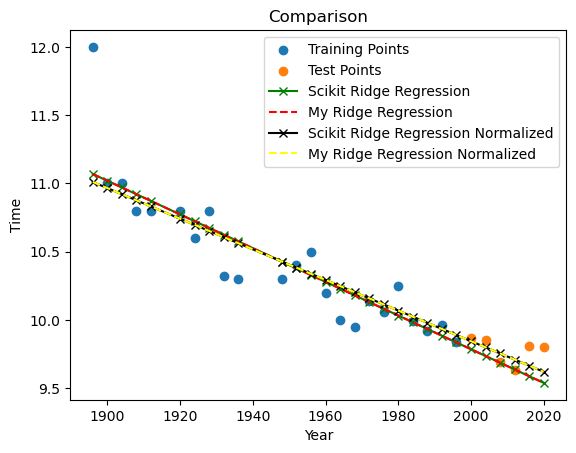

In [14]:
#plot if 1D
import warnings
warnings.filterwarnings('ignore')
if dataset_train.shape[1]==2:
    # plot the not normalized results with my model
    import matplotlib.pyplot as plt   
    ridge=Ridge_Regression(lambda_value)
    ridge.Train(X,Y)
    y_pred=ridge.Predict(np.concatenate((X,X_test),axis=0))
    # plot the normalized results with my model
    ridge_normalized=Ridge_Regression(lambda_value_normalized,normalize=True)
    ridge_normalized.Train(X,Y)
    y_pred_normalized=ridge_normalized.Predict(np.concatenate((X,X_test),axis=0))
    # plot the results with sklearn
    from sklearn.linear_model import Ridge
    ridge_sklearn=Ridge(alpha=lambda_value)
    ridge_sklearn.fit(X,Y)
    y_pred_sklearn=ridge_sklearn.predict(np.concatenate((X,X_test),axis=0))
    # plot the normalized results with sklearn
    from sklearn.preprocessing import StandardScaler
    scaler=StandardScaler()
    X_normalized=scaler.fit_transform(X)
    X_test_normalized=scaler.transform(X_test)
    ridge_sklearn_normalized=Ridge(alpha=lambda_value_normalized)
    ridge_sklearn_normalized.fit(X_normalized,Y)
    y_pred_sklearn_normalized=ridge_sklearn_normalized.predict(np.concatenate((X_normalized,X_test_normalized),axis=0))
    
    # plotting all together
    plt.scatter(X, Y, label='Training Points')
    plt.scatter(X_test, Y_test, label='Test Points')
    plt.plot(np.concatenate((X,X_test)), y_pred_sklearn, label='Scikit Ridge Regression', color='green', marker="x")
    plt.plot(np.concatenate((X,X_test)), y_pred, label='My Ridge Regression', linestyle='--', color='red')
    plt.plot(np.concatenate((X,X_test)), y_pred_sklearn_normalized, label='Scikit Ridge Regression Normalized', color='black', marker="x")
    plt.plot(np.concatenate((X,X_test)), y_pred_normalized, label='My Ridge Regression Normalized', linestyle='--', color='yellow')
    
    plt.title('Comparison')
    plt.xlabel('Year')
    plt.ylabel('Time')
    plt.legend()
    plt.show()